In [1]:
#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2 as cv
import json
import shutil
from PIL import Image

from ultralytics import YOLO
import yaml

In [3]:
CWD = os.getcwd()
DATA_DIR = "bdd-sample"
BDD_IMAGES_TRAIN = os.path.join(CWD,"resources",DATA_DIR,"images","train")
BDD_IMAGES_TEST = os.path.join(CWD,"resources",DATA_DIR,"images","test")
BDD_LABELS_TRAIN = os.path.join(CWD,"resources",DATA_DIR,"raw-labels","train")
BDD_LABELS_TEST = os.path.join(CWD,"resources",DATA_DIR,"raw-labels","test")
BDD_SEGMENTED_TRAIN = os.path.join(CWD,"resources",DATA_DIR,"segmented","color_labels","train")
BDD_SEGMENTED_VAL = os.path.join(CWD,"resources",DATA_DIR,"segmented","color_labels","val")
BDD_ENCLABELS_TRAIN = os.path.join(CWD,"resources",DATA_DIR,"labels","train")
BDD_ENCLABELS_TEST = os.path.join(CWD,"resources",DATA_DIR,"labels","test")

In [4]:
# just change what these vars below equal to pull from diff sources
train_images_paths = sorted(os.listdir(BDD_IMAGES_TRAIN))
test_images_paths = sorted(os.listdir(BDD_IMAGES_TEST))

train_labels_paths = sorted(os.listdir(BDD_LABELS_TRAIN))
test_labels_paths = sorted(os.listdir(BDD_LABELS_TEST))

#seg_train_images_paths = sorted(os.listdir(BDD_SEGMENTED_TRAIN))
#seg_test_images_paths = sorted(os.listdir(BDD_SEGMENTED_VAL))

## Load Images
Use Pillow cuz its easy, json.load()
Populate arrays containing image data and label data

In [5]:
#Load images based on a source directory where it comes from and the actual image
def load_images(images_dir,images_paths):
    images=[]
    for i in range(len(images_paths)):
        try:
            path = os.path.join(images_dir,images_paths[i])
            img = Image.open(path)
            images.append(img)
        except Exception as e:
            print(f"Error loading image {images_paths[i]}: {e}")
    return np.array(images)

In [6]:
#Load labels based on a source directory where it comes from and the actual label
def load_labels(labels_dir,labels_paths):
    labels=[]
    for i in range(len(labels_paths)):
        if labels_paths[i][-3:]=="txt":
            continue
        with open(os.path.join(labels_dir,labels_paths[i]),"r") as file:
            parsed = json.load(file)
            labels.append(parsed)
    return labels

In [7]:
print(train_images_paths[0], train_labels_paths[0])
print(len(train_labels_paths),len(test_labels_paths))
#print(len(seg_train_images_paths),seg_train_images_paths[0])

0004974f-05e1c285.jpg 0004974f-05e1c285.json
4000 2000


In [8]:
train_images = load_images(BDD_IMAGES_TRAIN,train_images_paths)
test_images = load_images(BDD_IMAGES_TEST,test_images_paths)
train_labels = load_labels(BDD_LABELS_TRAIN,train_labels_paths)
test_labels = load_labels(BDD_LABELS_TEST,test_labels_paths)

250.549246
(720, 1280, 3)


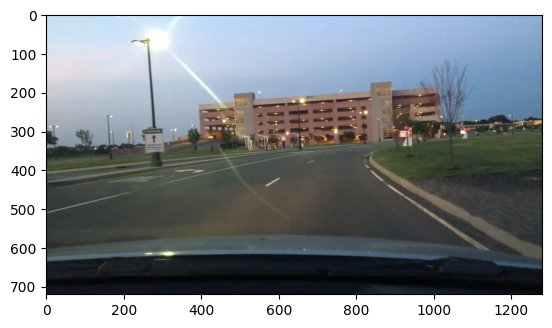

In [10]:
#testing out our data

#print(train_images[0])
print(train_labels[0]["frames"][0]["objects"][0]["box2d"]["x1"])
#get set of objects: train_labels[0]["frames"][0]["objects"]
#each object: object["attributes"]["box2d"]["x1"|"x2"|"y1"|"y2"]

print(train_images[0].shape)

# BUG WITH IMSHOW: THE EDITOR INVERTS THE COLORS SO YEAH USE SAVEFIG
plt.imshow(train_images[0])
plt.savefig('output_image.png', bbox_inches='tight', pad_inches=0)
plt.show()

## Work with images loaded

In [11]:
def get_object_area(ob):
    pt1,pt2=get_box_from_object(ob)
    return (pt2[0]-pt1[0]) * (pt2[1]-pt1[1])

def get_box_from_object(object):
    """
    for a labeled object for an image, find its bounding box
    :param object: object from label
    :return: 4 coordinates: x1, y1,  x2, y2
    """
    return (object["box2d"]["x1"],object["box2d"]["y1"]),(object["box2d"]["x2"],object["box2d"]["y2"])

def get_objects(label):
    """
    For a label json object containing json data labeling an image, find labeled objects
    Note: some objects include drivable roadways: remove those
    :param label: json object containing data
    :return: labeled objects in image
    """
    all_objs = label["frames"][0]["objects"]
    objs=[]
    areas = []
    for ob in all_objs:
        if "box2d" in ob and ob["category"]!="traffic sign": #only objects that have a bounding box
            objs.append(ob)
            areas.append(get_object_area(ob))
            #if get_object_area(ob)>50:
                #only append if has a bounding box and that box is bigger than 50 px
    
    swap_order = list(range(len(areas)))
    swap_order.sort(key=lambda x: areas[x], reverse=True) # sort based on descending order of areas
    swap_order = swap_order[:5] # take the 5 highest areas
    #print(swap_order)
    biggest = [objs[swap_order[i]] for i in range(len(swap_order))] # get those actual 5
    
    return biggest


In [12]:
def draw_box_on_axes(axes, point1, point2):
    rect = patches.Rectangle(point1, point2[0] - point1[0], point2[1] - point1[1], linewidth=1, edgecolor='b', facecolor='none')
    axes.add_patch(rect)

testing data so far
-draw boxes on features in the image

5


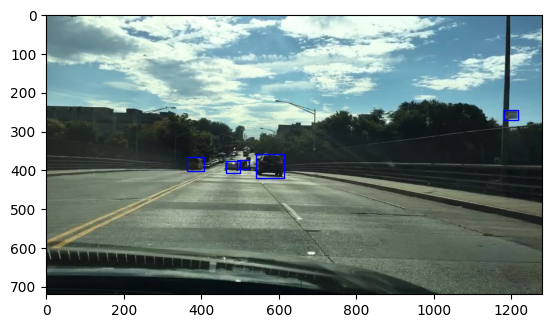

In [13]:
working = 5

img_1 = train_images[working]
label_1 = train_labels[working]
labeled_objects = get_objects(label_1)

print(len(labeled_objects))

fig, ax = plt.subplots()

ax.imshow(img_1)

for obj in labeled_objects:
    pt1, pt2 = get_box_from_object(obj)
    draw_box_on_axes(ax,pt1,pt2)

plt.savefig('output_image.png', bbox_inches='tight', pad_inches=0)
plt.show()

#plt.grid(False)

## Model Training and Creation

basically we hella fucked up and are not supposed to use some tensorflow cnn or anything but actually YOLO or like an object detection model

Idea is to isolate the objects inside train_images test_images and their respective object categories
given variables: train_images, train_labels, test_images, test_labels
turn them into:
    train_objects
        -stream of objects from all the images (all compiled together in one big arr)
        -all standardized at some 

#dont need
def get_iso_object_images(img, objs):
    """
    Cuts each object in the list from the image and returns a list of the objects
    :param img: og image where objects originate from
    :param objs: list of coordinates representing the objects
    :return: list of cut objects
    """
    cut_imgs = []
    for ob in objs:
        pt1,pt2 = get_box_from_object(ob)
        pt1 = tuple(int(i) for i in pt1)
        pt2 = tuple(int(i) for i in pt2)
        cut = np.copy(img)
        cut_imgs.append(cut[pt1[1]:pt2[1],pt1[0]:pt2[0]])
    return cut_imgs

time complexity is bad for this

In [14]:
def compile_cats(labels):
    """
    Find the total # of categories and encode them
    :param labels: Labels under a set of data that have objects with categories needing to be compiled
    :return: Compiled list of cats extracted with [i][j]th item representing ith image's jth object's category
    """
    obj_cats = []
    for a in range(len(labels)):
        obj_cats.append([])
        ob_cats = get_objects(labels[a])
        obj_cats[a].extend([ob["category"] for ob in ob_cats])
    return obj_cats

#find total number of categories and encode them
#train_objects = []
train_cats = []
for i in range(len(train_images)):
    train_cats.append([])
    ob_cats = get_objects(train_labels[i])
    #obj_imgs = get_iso_object_images(train_images[i], objects)
    #train_objects.extend(obj_imgs)
    train_cats[i].extend([ob["category"] for ob in ob_cats])

now that we have working objects and labels finalize data format
encode object categories

In [15]:
def encode_cats(all_raw_cats):
    """
    Encode cats into numbers from a list of raw cats
    :param all_raw_cats: list of each dataset each with their own raw cats 
    :return: encoded list of each image's respective enc cats + encoding used
    """
    cats = {}
    all_cats_encoded = []
    for a in range(len(all_raw_cats)):
        all_cats_encoded.append([])
        curr_raw_cat = all_raw_cats[a]
        for b in range(len(curr_raw_cat)):
            all_cats_encoded[a].append([])
            for ob_cat in curr_raw_cat[b]:
                if ob_cat not in cats:
                    cats[ob_cat]=len(cats)
                all_cats_encoded[a][b].append(cats[ob_cat])
    return cats,all_cats_encoded

In [16]:
train_cats = compile_cats(train_labels)
test_cats = compile_cats(test_labels)

raw_cats_data = [train_cats,test_cats]
cats_key, all_cats_enc = encode_cats(raw_cats_data)
print(cats_key)

In [17]:
def convert_pts_to_yolo(p1,p2,img_width,img_height):
    x1,y1=p1
    x2,y2=p2
    x_center = (x1 + x2) / 2 / img_width
    y_center = (y1 + y2) / 2 / img_height
    width = (x2 - x1) / img_width
    height = (y2 - y1) / img_height
    return x_center, y_center, width, height

def write_text_from_data(ind,img,label,cats_enc,directory):
    """
    Given image and label, find image and object and its objects and create an entry for each that names its category along with data about its bounding box, write to a new file for the image that the objects came from. Use the key and encoded categories to help encode entries.
    """
    filename = label["name"]+".txt"
    
    objects = get_objects(label)
    
    with open(os.path.join(directory,filename),"w") as f:
        for a in range(len(objects)):
            pt1, pt2 = get_box_from_object(objects[a])
            img_h,img_w = img.shape[:2]
            xc,yc,w,h = convert_pts_to_yolo(pt1,pt2,img_w,img_h)
            #write file
            f.write(f"{cats_enc[ind][a]} {xc} {yc} {w} {h}\n")

#test the encoding of categories
print(cats)

In [18]:
for i in range(len(train_images)):
    write_text_from_data(i,train_images[i],train_labels[i],all_cats_enc[0],BDD_ENCLABELS_TRAIN)
for i in range(len(test_images)):
    write_text_from_data(i,test_images[i],test_labels[i],all_cats_enc[1],BDD_ENCLABELS_TEST)

In [19]:
data_yaml = {
    'path': os.path.join(CWD,"resources",DATA_DIR),
    'train': os.path.join(CWD,"resources",DATA_DIR,"train"),
    'val': os.path.join(CWD,"resources",DATA_DIR,"val"),
    'names': {str(v):k for k,v in cats_key.items()}
}

with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

In [20]:
#train_images_paths
#test_images_paths
train_enclabels_paths = sorted(os.listdir(BDD_ENCLABELS_TRAIN))
test_enclabels_paths = sorted(os.listdir(BDD_ENCLABELS_TEST))

for i in range(len(train_images_paths)):
    from_file = os.path.join(BDD_IMAGES_TRAIN,train_images_paths[i])
    to_file = os.path.join(CWD,"resources",DATA_DIR,"train","images")
    shutil.copy(from_file,to_file)
for i in range(len(test_images_paths)):
    from_file = os.path.join(BDD_IMAGES_TEST,test_images_paths[i])
    to_file = os.path.join(CWD,"resources",DATA_DIR,"val","images")
    shutil.copy(from_file,to_file)
for i in range(len(train_enclabels_paths)):
    from_file = os.path.join(BDD_ENCLABELS_TRAIN,train_enclabels_paths[i])
    to_file = os.path.join(CWD,"resources",DATA_DIR,"train","labels")
    shutil.copy(from_file,to_file)
for i in range(len(test_enclabels_paths)):
    from_file = os.path.join(BDD_ENCLABELS_TEST,test_enclabels_paths[i])
    to_file = os.path.join(CWD,"resources",DATA_DIR,"val","labels")
    shutil.copy(from_file,to_file)

In [21]:
#testing file structure validity
for i in range(len(train_images_paths)):
    if train_images_paths[i][:-4] != train_enclabels_paths[i][:-4]:
        print("f")

In [22]:
model = YOLO("yolov8n.pt")  # or yolov8n.pt
model.train(data="data.yaml", epochs=10, imgsz=384, batch=8, device="mps")

#results = model.predict(source="myimg.jpg", save=True, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.162 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.159  Python-3.13.5 torch-2.7.1+cpu CPU (Intel Core(TM) Ultra 7 155H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=384, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, 

train: Scanning C:\Users\Samuel Du\Desktop\IdeaProjects\service-eye\resources\bdd-sample\train\labels.cache... 3952 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3952/3952 [00:00<?, ?it/s]

val: Fast image access  (ping: 0.00.0 ms, read: 279.549.5 MB/s, size: 54.1 KB)



C:\Users\Samuel Du\Desktop\IdeaProjects\service-eye\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\Samuel Du\Desktop\IdeaProjects\service-eye\resources\bdd-sample\val\labels.cache... 1945 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1945/1945 [00:00<?, ?it/s]
C:\Users\Samuel Du\Desktop\IdeaProjects\service-eye\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to C:\Users\Samuel Du\Desktop\IdeaProjects\service-eye\runs\detect\train5\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 384 train, 384 val
Using 0 dataloader workers
Logging results to C:\Users\Samuel Du\Desktop\IdeaProjects\service-eye\runs\detect\train5
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


C:\Users\Samuel Du\Desktop\IdeaProjects\service-eye\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/10         0G      1.422      1.984      1.078         39        384: 100%|██████████| 494/494 [09:31<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 122/122 [01:21<00:00,  1.49it/s]


                   all       1945       9654      0.522      0.158      0.142     0.0857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.334       1.35      1.064         39        384: 100%|██████████| 494/494 [06:58<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 122/122 [00:48<00:00,  2.51it/s]


                   all       1945       9654      0.526      0.194       0.16     0.0991

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.301      1.243      1.055         40        384: 100%|██████████| 494/494 [04:42<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 122/122 [00:38<00:00,  3.16it/s]

                   all       1945       9654      0.551      0.171      0.177      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G       1.28      1.157      1.049         37        384: 100%|██████████| 494/494 [04:58<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 122/122 [00:38<00:00,  3.14it/s]

                   all       1945       9654      0.337      0.224      0.177      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G       1.24      1.083      1.032         36        384: 100%|██████████| 494/494 [04:48<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 122/122 [00:41<00:00,  2.97it/s]

                   all       1945       9654      0.285      0.222        0.2      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.207      1.046      1.022         38        384: 100%|██████████| 494/494 [04:55<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 122/122 [00:38<00:00,  3.18it/s]

                   all       1945       9654      0.347      0.246      0.214      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.182     0.9992      1.011         36        384: 100%|██████████| 494/494 [04:48<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 122/122 [00:39<00:00,  3.06it/s]

                   all       1945       9654      0.314      0.254      0.225      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.147     0.9519     0.9941         36        384: 100%|██████████| 494/494 [05:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 122/122 [00:38<00:00,  3.17it/s]

                   all       1945       9654      0.345      0.265      0.238       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.134     0.9212     0.9865         36        384: 100%|██████████| 494/494 [04:49<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 122/122 [00:39<00:00,  3.11it/s]

                   all       1945       9654      0.301      0.278      0.247      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.113     0.8909     0.9808         34        384: 100%|██████████| 494/494 [04:48<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 122/122 [00:38<00:00,  3.16it/s]


                   all       1945       9654      0.351      0.279       0.25       0.16

10 epochs completed in 1.047 hours.
Optimizer stripped from C:\Users\Samuel Du\Desktop\IdeaProjects\service-eye\runs\detect\train5\weights\last.pt, 6.2MB
Optimizer stripped from C:\Users\Samuel Du\Desktop\IdeaProjects\service-eye\runs\detect\train5\weights\best.pt, 6.2MB

Validating C:\Users\Samuel Du\Desktop\IdeaProjects\service-eye\runs\detect\train5\weights\best.pt...
Ultralytics 8.3.159  Python-3.13.5 torch-2.7.1+cpu CPU (Intel Core(TM) Ultra 7 155H)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 122/122 [00:33<00:00,  3.62it/s]


                   all       1945       9654       0.35      0.281       0.25       0.16
          traffic sign        612       1028      0.416      0.302      0.285      0.164
                person        260        398      0.456      0.359      0.337      0.178
                   car       1899       7171      0.714      0.711      0.755      0.528
                   bus        166        199      0.344      0.367      0.273       0.21
                 truck        401        513      0.442      0.444      0.361      0.257
         traffic light        160        239       0.39     0.0753        0.1     0.0364
                 rider         27         28      0.388      0.339      0.263      0.169
                  bike         41         48     0.0937      0.104     0.0562     0.0187
                 motor         26         29      0.254      0.103     0.0705     0.0362
                 train          1          1          0          0          0          0
Speed: 0.1ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001CB5023C230>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,   

In [25]:
results = model.predict(source=0, show=True)


1/1: 0... Success  (inf frames of shape 640x480 at 30.00 FPS)

WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

0: 288x384 (no detections), 81.9ms
0: 288x384 (no detections), 79.9ms
0: 288x384 (no detections), 88.6ms
0: 288x384 (no detections), 65.5ms
0: 288x384 (no detections), 55.0ms
0: 288x384 (no detections), 54.3ms
0: 288x384 (no detections), 56.3ms
0: 288x384 (no detections), 49.6ms
0: 288x384 (no detections), 53.1ms
0: 288x384 (no detections), 71.1ms
0: 288x384 (no detections), 76.1ms
0: 288x384 

KeyboardInterrupt: 

In [26]:
model = YOLO("./runs/detect/train3/weights/best.pt")  # or yolov8n.pt
results = model.predict(source=2, show=True)

FileNotFoundError: [Errno 2] No such file or directory: 'runs\\detect\\train3\\weights\\best.pt'

## Tensorflow stuff that is bad
dont need ts damn

In [42]:
#tf model
model = tf.keras.Sequential([
    tf.keras.layers.Input((None, None, 1)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])

In [43]:
#model compilation and tf loss funct
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#run training
model.fit(train_objects, train_cats_enc, epochs=10)

In [ ]:
#run loss function
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)